In [ ]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
from collections import defaultdict

from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Automatické přenačítání modulů při změně
%load_ext autoreload
%autoreload 2

# Přidání složky 'src' do cesty Pythonu
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import našich modulů
import config
import models
import load_preprocess_data as loader 
import analysis
# from models import 
import visualization as viz
viz.setup_style()

# Pro zobrazení grafů přímo v notebooku:
%matplotlib inline

print("✅ Knihovny načteny.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
🎨 Vizualizační styl nastaven: whitegrid
✅ Knihovny načteny.


[autoreload of visualization failed: Traceback (most recent call last):
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\dobes\Documents\Anaconda Python\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x83 in position 6892: character maps to <undefined>
]


In [2]:
def load_data_for_scenario(scenario, filter_type='aggressive', test_size=0.2, random_state=42):
    """
    Načte a namíchá data podle scénáře (S1a - S1e).
    Vrací: X_train, X_test, y_train, y_test
    """
    # Cesty k datům
    path_gold_l0 = config.VECTORS_DIR / 'gold' / f"gold_token_{filter_type}_l0.pkl"
    path_gold_l1 = config.VECTORS_DIR / 'gold' / f"gold_token_{filter_type}_l1.pkl"
    path_silver_l0 = config.VECTORS_DIR / 'silver' / f"silver_token_{filter_type}_l0.pkl"
    path_silver_l1 = config.VECTORS_DIR / 'silver' / f"silver_token_{filter_type}_l1.pkl"

    # Načtení základních bloků (pokud existují)
    def load_block(path):
        if not path.exists(): return np.array([])
        with open(path, 'rb') as f: return pickle.load(f)

    g_l0 = load_block(path_gold_l0)
    g_l1 = load_block(path_gold_l1)
    s_l0 = load_block(path_silver_l0)
    s_l1 = load_block(path_silver_l1)
    
    # --- LOGIKA SCÉNÁŘŮ ---
    
    # S1a: Baseline (Gold Imbalanced) - Všechno Gold L0 + L1
    if scenario == 'S1a':
        X = np.concatenate([g_l0, g_l1])
        y = np.concatenate([np.zeros(len(g_l0)), np.ones(len(g_l1))])
        # Split
        return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    # S1b: Gold Balanced - Undersampling L0 na počet L1
    elif scenario == 'S1b':
        X = np.concatenate([g_l0, g_l1])
        y = np.concatenate([np.zeros(len(g_l0)), np.ones(len(g_l1))])
        # Undersampling
        rus = RandomUnderSampler(random_state=random_state)
        X_res, y_res = rus.fit_resample(X, y)
        return train_test_split(X_res, y_res, test_size=test_size, stratify=y_res, random_state=random_state)

    # S1d: Train Noisy (Silver), Test Clean (Gold)
    elif scenario == 'S1d':
        # Train: Silver L0 + Silver L1 (nebo mix, záleží jak definujeme "Noisy")
        # Zde bereme čistě Silver pro trénink
        X_train = np.concatenate([s_l0, s_l1])
        y_train = np.concatenate([np.zeros(len(s_l0)), np.ones(len(s_l1))])
        
        # Test: Gold L0 + Gold L1
        X_test = np.concatenate([g_l0, g_l1])
        y_test = np.concatenate([np.zeros(len(g_l0)), np.ones(len(g_l1))])
        
        # Balancování tréninku (volitelné, ale doporučené pro stabilitu)
        rus = RandomUnderSampler(random_state=random_state)
        X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)
        
        return X_train_bal, X_test, y_train_bal, y_test

    # S1e: Hybrid (Max L1 Gold+Silver + Clean Balanced L0)
    elif scenario == 'S1e':
        # Všechny anomálie
        all_l1 = np.concatenate([g_l1, s_l1])
        n_anomalies = len(all_l1)
        
        # L0 bereme jen z Gold (kvalitní), ale tolik, aby to bylo 1:1 k anomáliím
        # Pokud nemáme dost Gold L0, musíme si pomoct Silver L0
        if len(g_l0) >= n_anomalies:
            # Máme dost Gold L0
            X_l0_selected = g_l0[:n_anomalies] # (zjednodušený výběr, lepší je random choice)
            idx = np.random.choice(len(g_l0), n_anomalies, replace=False)
            X_l0_selected = g_l0[idx]
        else:
            # Nemáme dost Gold L0, doplníme Silver L0
            missing = n_anomalies - len(g_l0)
            s_l0_subset = s_l0[:missing] # Zase zjednodušeně
            X_l0_selected = np.concatenate([g_l0, s_l0_subset])
            
        X = np.concatenate([X_l0_selected, all_l1])
        y = np.concatenate([np.zeros(len(X_l0_selected)), np.ones(len(all_l1))])
        
        return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    else:
        raise ValueError(f"Neznámý scénář: {scenario}")

### Data-check

In [3]:
# Seznam scénářů, které chceme zkontrolovat
# S1c vynecháme (nebo nahradíme S1b), protože S1c je jen opakované S1b
CHECK_SCENARIOS = ['S1a', 'S1b', 'S1d', 'S1e'] 
CHECK_FILTERS = ['aggressive'] # Stačí zkontrolovat jeden filtr, ať to není dlouhé

print(f"📊 DATA INSPECTION (Sanity Check)\n")

for scen in CHECK_SCENARIOS:
    print(f"🌍 SCÉNÁŘ: {scen}")
    for f_type in CHECK_FILTERS:
        try:
            # S1c je to samé co S1b, jen se mění seed, pro kontrolu stačí načíst jako S1b
            load_key = 'S1b' if scen == 'S1c' else scen
            
            X_train, X_test, y_train, y_test = load_data_for_scenario(
                load_key, 
                filter_type=f_type, 
                random_state=42
            )
            
            # Analýza labelů (počty 0 a 1)
            unique, counts = np.unique(y_train, return_counts=True)
            train_counts = dict(zip(unique, counts))
            l0_count = train_counts.get(0.0, 0)
            l1_count = train_counts.get(1.0, 0)
            ratio = l0_count / l1_count if l1_count > 0 else 0
            
            print(f"      Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")
            print(f"      Train Balance: L0 (Clean): {l0_count} vs L1 (Anom): {l1_count}")
            print(f"      Ratio L0/L1: {ratio:.2f}")
            
            # Rychlá kontrola logiky
            if scen == 'S1a' and ratio < 5:
                print("      ⚠️ VAROVÁNÍ: S1a by mělo být nevyvážené (hodně L0)!")
            elif scen == 'S1b' and abs(ratio - 1.0) > 0.1:
                print("      ⚠️ VAROVÁNÍ: S1b by mělo být vyvážené (1.0)!")
            elif scen == 'S1d':
                print("      ℹ️ Info: U S1d ověřte, že Train je větší (Silver) než Test (Gold).")
                
        except Exception as e:
            print(f"      ❌ CHYBA: {e}")
            
    print("-" * 50)

📊 DATA INSPECTION (Sanity Check)

🌍 SCÉNÁŘ: S1a
      Train Shape: (1195, 768) | Test Shape: (299, 768)
      Train Balance: L0 (Clean): 1001 vs L1 (Anom): 194
      Ratio L0/L1: 5.16
--------------------------------------------------
🌍 SCÉNÁŘ: S1b
      Train Shape: (387, 768) | Test Shape: (97, 768)
      Train Balance: L0 (Clean): 193 vs L1 (Anom): 194
      Ratio L0/L1: 0.99
--------------------------------------------------
🌍 SCÉNÁŘ: S1d
      Train Shape: (1738, 768) | Test Shape: (1494, 768)
      Train Balance: L0 (Clean): 869 vs L1 (Anom): 869
      Ratio L0/L1: 1.00
      ℹ️ Info: U S1d ověřte, že Train je větší (Silver) než Test (Gold).
--------------------------------------------------
🌍 SCÉNÁŘ: S1e
      Train Shape: (1777, 768) | Test Shape: (445, 768)
      Train Balance: L0 (Clean): 888 vs L1 (Anom): 889
      Ratio L0/L1: 1.00
--------------------------------------------------


### Training Loop

In [10]:
# --- KONFIGURACE ---
RESULTS_PATH = config.RESULTS_DIR / "M2_S1_experiment_results.csv"
SCENARIOS_TO_RUN = ['S1a', 'S1b', 'S1d', 'S1e']
FILTERS = ['none', 'mild', 'aggressive']
MODEL_NAMES = ["LogReg", "SVM (RBF)", "XGBoost", "Dummy", "SVM (Lin)", "NaiveBayes", "RandForest"] 

# NOVÁ DEFINICE SLOUPCŮ (Train i Test)
ALL_COLUMNS = [
    'scenario', 'filter', 'model', 
    'train_time_sec',
    
    # Testovací metriky
    'test_auprc', 'test_roc_auc', 'test_max_f1', 
    'test_precision_at_max_f1', 'test_recall_at_max_f1',
    
    # Trénovací metriky (pro kontrolu overfittingu)
    'train_auprc', 'train_roc_auc', 'train_max_f1',
    'train_precision_at_max_f1', 'train_recall_at_max_f1'
]

# Inicializace CSV (pokud existuje STARÝ soubor, smažte ho ručně nebo odkomentujte unlink)
if RESULTS_PATH.exists():
    print(f"⚠️ Soubor existuje: {RESULTS_PATH}")
    # RESULTS_PATH.unlink() # <--- ODKOMENTOVAT POKUD CHCEME SMAZAT STARÝ
else:
    pd.DataFrame(columns=ALL_COLUMNS).to_csv(RESULTS_PATH, index=False)
    print(f"🆕 Vytvořen nový soubor: {RESULTS_PATH}")

🆕 Vytvořen nový soubor: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M2_S1_experiment_results.csv


In [11]:
def calculate_metrics_at_max_f1(y_true, y_probs):
    """
    Vypočítá AUPRC, AUROC a najde Precision/Recall v bodě maximálního F1.
    """
    # 1. Základní křivky
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    auprc = auc(recall, precision)
    roc_auc = roc_auc_score(y_true, y_probs)
    
    # 2. Hledání Max F1
    # F1 = 2 * (P * R) / (P + R)
    numerator = 2 * precision * recall
    denominator = precision + recall
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    
    ix = np.argmax(f1_scores)
    max_f1 = f1_scores[ix]
    best_prec = precision[ix]
    best_rec = recall[ix]
    
    return auprc, roc_auc, max_f1, best_prec, best_rec

In [12]:
def run_scenario_experiment(scenario, filters, models_list, csv_path):
    """
    Spustí experimenty a ukládá TRAIN i TEST metriky.
    """
    print(f"\n{'='*60}")
    print(f"🌍 SPUŠTÍM SCÉNÁŘ: {scenario}")
    print(f"{'='*60}")

    n_runs = 20 if scenario == 'S1c' else 1
    load_scenario_key = 'S1b' if scenario == 'S1c' else scenario

    for f_type in filters:
        pbar = tqdm(models_list, desc=f"Models ({scenario}/{f_type})")
        shape_printed = False
        
        for model_name in pbar:
            for i in range(n_runs):
                run_id = i if scenario == 'S1c' else 0
                seed = 42 + i 
                
                try:
                    # 1. Načtení dat
                    X_train, X_test, y_train, y_test = load_data_for_scenario(
                        load_scenario_key, 
                        filter_type=f_type, 
                        random_state=seed
                    )
                    
                    # Info výpis (jen jednou)
                    if not shape_printed:
                        unique, counts = np.unique(y_train, return_counts=True)
                        counts_dict = dict(zip(unique, counts))
                        ratio_str = f"L0:{counts_dict.get(0.0, 0)} | L1:{counts_dict.get(1.0, 0)}"
                        tqdm.write(f"   📊 DATA INFO [{f_type}]: Train {X_train.shape} ({ratio_str}) | Test {X_test.shape}")
                        shape_printed = True
                    
                    # 2. Init Model
                    clf = models.get_supervised_model(model_name, random_state=42)
                    
                    # 3. Trénink
                    start_time = time.time()
                    clf.fit(X_train, y_train)
                    train_time = time.time() - start_time
                    
                    # 4. Predikce (TRAIN i TEST)
                    if hasattr(clf, "predict_proba"):
                        y_test_probs = clf.predict_proba(X_test)[:, 1]
                        y_train_probs = clf.predict_proba(X_train)[:, 1] # <--- Predikce na trainu
                    else:
                        y_test_probs = clf.decision_function(X_test)
                        y_train_probs = clf.decision_function(X_train) # <--- Predikce na trainu
                    
                    # 5. Výpočet metrik
                    # A) TEST
                    te_auprc, te_roc, te_f1, te_prec, te_rec = calculate_metrics_at_max_f1(y_test, y_test_probs)
                    
                    # B) TRAIN
                    tr_auprc, tr_roc, tr_f1, tr_prec, tr_rec = calculate_metrics_at_max_f1(y_train, y_train_probs)
                    
                    # 6. Uložení
                    res_entry = {
                        'scenario': scenario,
                        'filter': f_type,
                        'model': model_name,
                        'run_id': run_id,
                        'train_time_sec': train_time,
                        
                        # Test stats
                        'test_auprc': te_auprc,
                        'test_roc_auc': te_roc,
                        'test_max_f1': te_f1,
                        'test_precision_at_max_f1': te_prec,
                        'test_recall_at_max_f1': te_rec,
                        
                        # Train stats
                        'train_auprc': tr_auprc,
                        'train_roc_auc': tr_roc,
                        'train_max_f1': tr_f1,
                        'train_precision_at_max_f1': tr_prec,
                        'train_recall_at_max_f1': tr_rec
                    }
                    
                    pd.DataFrame([res_entry], columns=ALL_COLUMNS).to_csv(csv_path, mode='a', header=False, index=False)
                    
                except Exception as e:
                    tqdm.write(f"      ❌ Chyba: {model_name} (Run {run_id}): {e}")
                    continue

In [13]:
# --- SPUŠTĚNÍ VŠECH SCÉNÁŘŮ ---

# 1. Standardní scénáře (S1a, S1b, S1d, S1e)
standard_scenarios = [s for s in SCENARIOS_TO_RUN if s != 'S1c']

for scen in standard_scenarios:
    run_scenario_experiment(scen, FILTERS, MODEL_NAMES, RESULTS_PATH)

print(f"\n✅ VŠECHNO HOTOVO! Výsledky uloženy v {RESULTS_PATH}")



🌍 SPUŠTÍM SCÉNÁŘ: S1a


Models (S1a/none):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [none]: Train (1885, 768) (L0:1641 | L1:244) | Test (472, 768)


Models (S1a/mild):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [mild]: Train (1223, 768) (L0:1020 | L1:203) | Test (306, 768)


Models (S1a/aggressive):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [aggressive]: Train (1195, 768) (L0:1001 | L1:194) | Test (299, 768)

🌍 SPUŠTÍM SCÉNÁŘ: S1b


Models (S1b/none):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [none]: Train (488, 768) (L0:244 | L1:244) | Test (122, 768)


Models (S1b/mild):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [mild]: Train (406, 768) (L0:203 | L1:203) | Test (102, 768)


Models (S1b/aggressive):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [aggressive]: Train (387, 768) (L0:193 | L1:194) | Test (97, 768)

🌍 SPUŠTÍM SCÉNÁŘ: S1d


Models (S1d/none):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [none]: Train (1836, 768) (L0:918 | L1:918) | Test (2357, 768)


Models (S1d/mild):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [mild]: Train (1780, 768) (L0:890 | L1:890) | Test (1529, 768)


Models (S1d/aggressive):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [aggressive]: Train (1738, 768) (L0:869 | L1:869) | Test (1494, 768)

🌍 SPUŠTÍM SCÉNÁŘ: S1e


Models (S1e/none):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [none]: Train (1956, 768) (L0:978 | L1:978) | Test (490, 768)


Models (S1e/mild):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [mild]: Train (1830, 768) (L0:915 | L1:915) | Test (458, 768)


Models (S1e/aggressive):   0%|          | 0/7 [00:00<?, ?it/s]

   📊 DATA INFO [aggressive]: Train (1777, 768) (L0:888 | L1:889) | Test (445, 768)

✅ VŠECHNO HOTOVO! Výsledky uloženy v C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M2_S1_experiment_results.csv


### Analýza výsledků

Generuji detailní grafy...


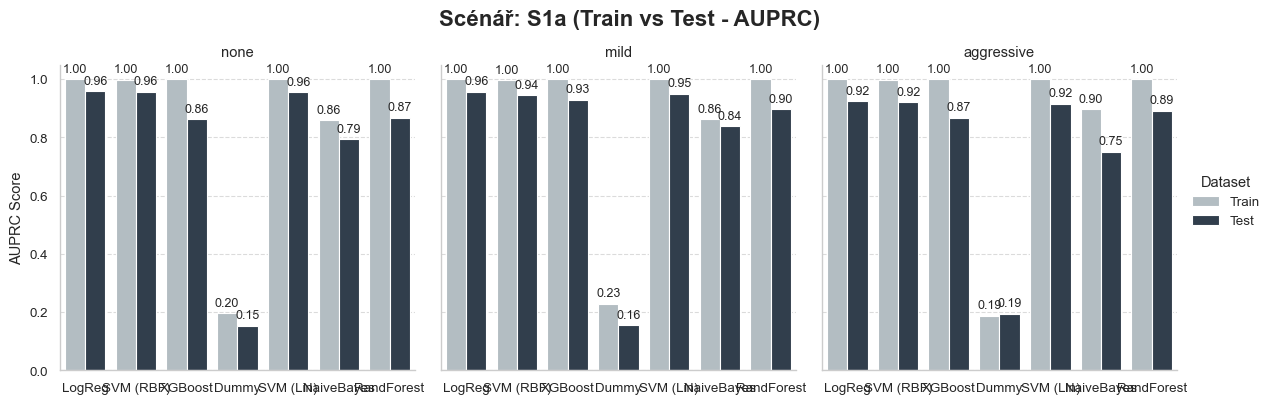

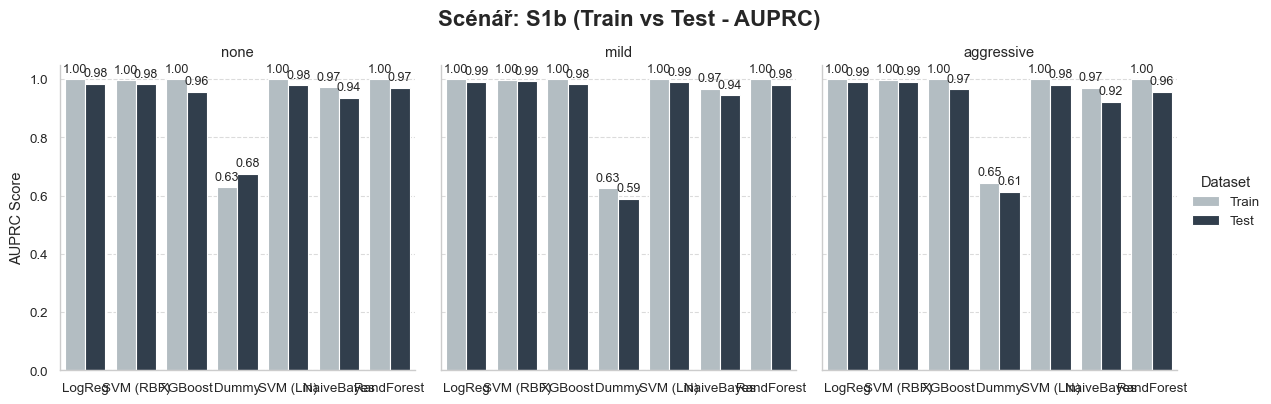

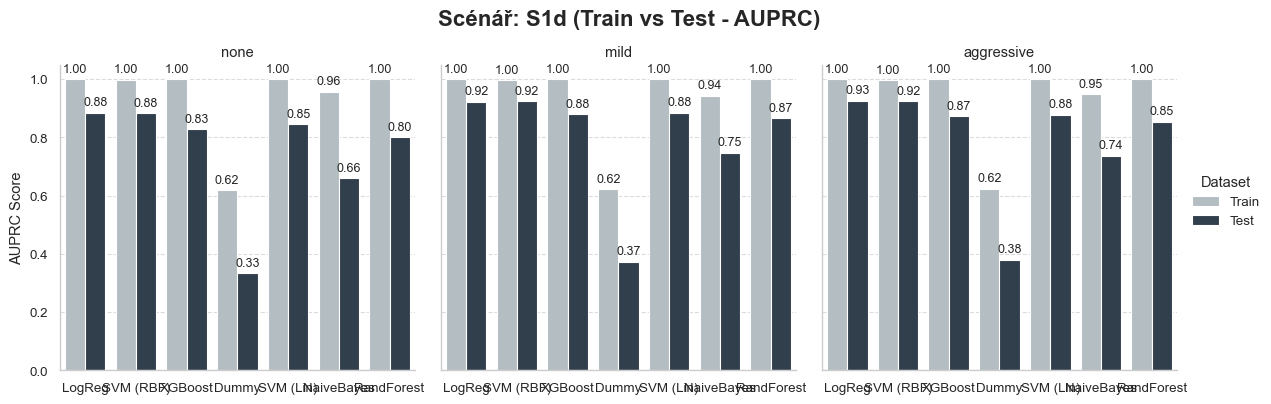

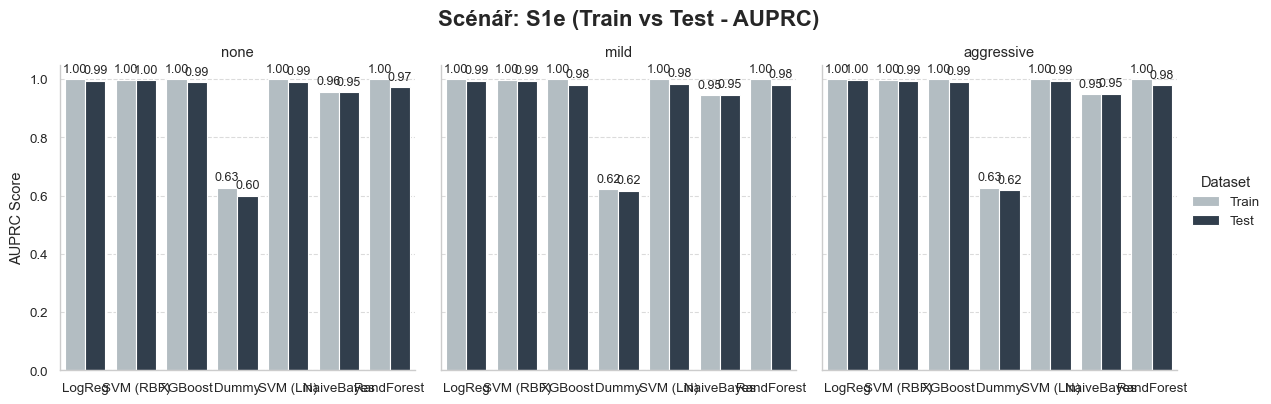

In [14]:
# Načtení výsledků
if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    
    # 1. Detailní grafy po scénářích (Uloží se do RESULTS_DIR nebo zobrazí)
    print("Generuji detailní grafy...")
    viz.plot_scenario_breakdown(df_results, metric='auprc')
    
    # 2. Globální graf ("Big Picture")
    # print("Generuji globální srovnání...")
    # viz.plot_global_comparison(df_res, metric='auprc')

### Výběr nejlepšího modelu, retraining a analýza

In [15]:
from itables import show

# --- VŠECHNY VÝSLEDKY ---
print("VŠECHNY VÝSLEDKY:")

show(df_results)

VŠECHNY VÝSLEDKY:


Loading ITables v2.6.2 from the internet... (need help?)


### Výběr nejlepšího modelu, retraining a analýza

In [22]:
# --- 1. VÝBĚR VÍTĚZE ---
# Seřadíme podle AUPRC sestupně
metric_col = 'test_auprc' 
best_run = df_results.sort_values(by=metric_col, ascending=False).iloc[0]

# Vytáhneme parametry vítězného experimentu
best_scenario = best_run['scenario']
best_filter = best_run['filter']
best_model_name = best_run['model']

print(f"🏆 VÍTĚZNÝ EXPERIMENT:")
print(f"   Model:   {best_model_name}")
print(f"   Scénář:  {best_scenario}")
print(f"   Filtr:   {best_filter}")
print(f"   Skóre:   {best_run[metric_col]:.4f}")

# --- 2. NAČTENÍ DAT PRO KONKRÉTNÍ SCÉNÁŘ ---
# Zde voláme vaši funkci s parametry vítěze
print(f"\n🔄 Načítám data pro scénář {best_scenario} a filtr {best_filter}...")

X_train, X_test, y_train, y_test = load_data_for_scenario(
    scenario=best_scenario,
    filter_type=best_filter,
    random_state=42
)

print(f"   Train shape: {X_train.shape} (Anomalies: {sum(y_train)})")
print(f"   Test shape:  {X_test.shape}  (Anomalies: {sum(y_test)})")

# --- 3. RETRAINING (PŘETRÉNOVÁNÍ) ---
# Inicializujeme čistý model
clf = models.get_supervised_model(best_model_name)

print(f"🛠️  Přetrénovávám model na {len(X_train)} vzorcích...")
clf.fit(X_train, y_train)

# --- 4. PREDIKCE PRO VIZUALIZACI ---
# Potřebujeme pravděpodobnosti pro křivky a kalibraci
if hasattr(clf, "predict_proba"):
    y_probs = clf.predict_proba(X_test)[:, 1]
else:
    # Fallback pro modely bez probability (např. SVM linear bez probability=True)
    y_probs = clf.decision_function(X_test)
    # Normalizace do 0-1 pro vizualizaci (pokud je to decision function)
    y_probs = (y_probs - y_probs.min()) / (y_probs.max() - y_probs.min())

y_pred = clf.predict(X_test)

print("✅ Model přetrénován a připraven k vizualizaci.")

🏆 VÍTĚZNÝ EXPERIMENT:
   Model:   LogReg
   Scénář:  S1e
   Filtr:   aggressive
   Skóre:   0.9971

🔄 Načítám data pro scénář S1e a filtr aggressive...
   Train shape: (1777, 768) (Anomalies: 889.0)
   Test shape:  (445, 768)  (Anomalies: 222.0)
🛠️  Přetrénovávám model na 1777 vzorcích...
✅ Model přetrénován a připraven k vizualizaci.


📊 1. KLASICKÉ METRIKY


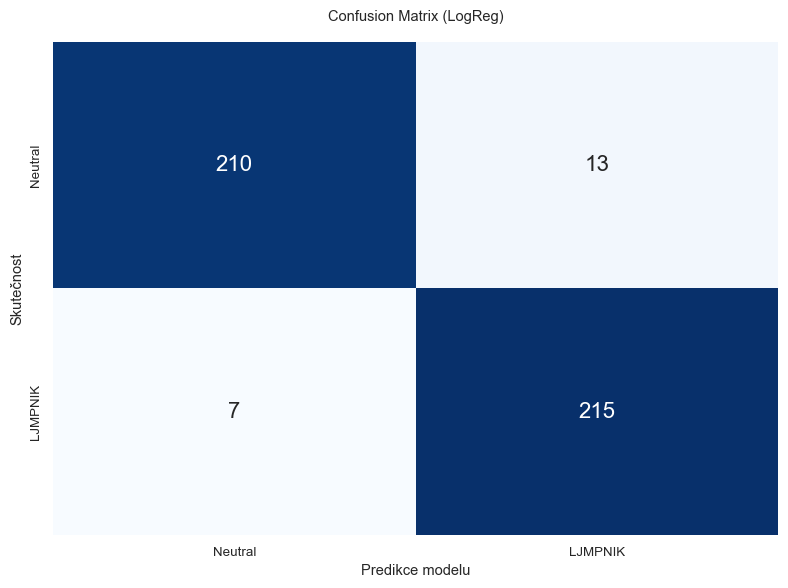

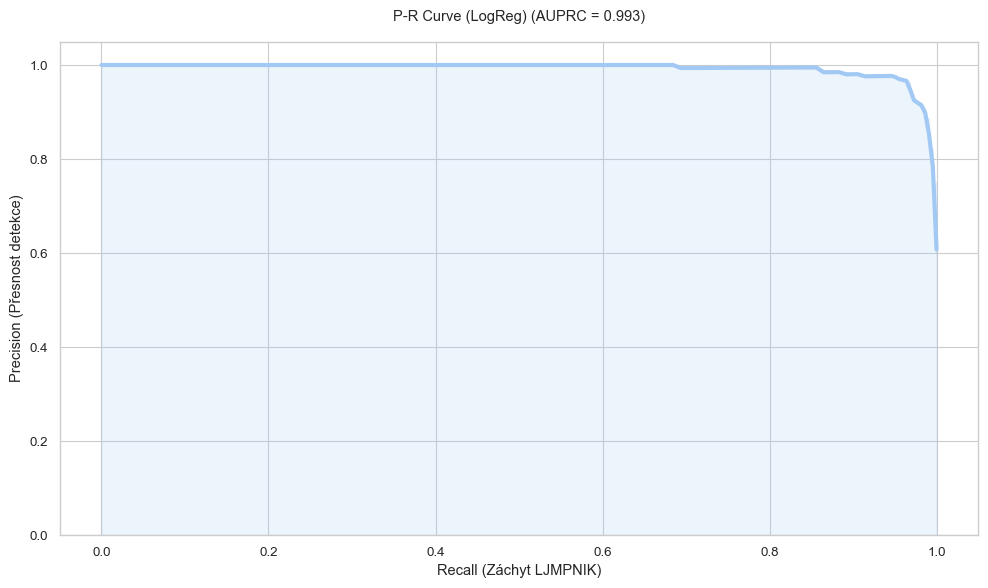

In [24]:
# Reloadnutí vizualizace, aby se načetly nové funkce
import visualization as viz
from importlib import reload
reload(viz)

print("📊 1. KLASICKÉ METRIKY")
# Ověření, zda existují proměnné, jinak doplní dummy názvy
title_suffix = best_run['model'] if 'best_run' in locals() else "Model"

viz.plot_confusion_matrix_heatmap(y_test, y_pred, title=f"Confusion Matrix ({title_suffix})")
viz.plot_pr_curve(y_test, y_probs, title=f"P-R Curve ({title_suffix})")


📊 2. KALIBRACE A DŮLEŽITOST RYSŮ


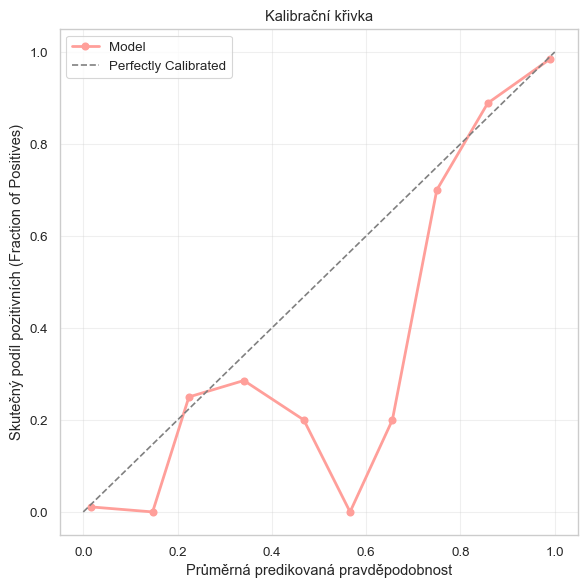

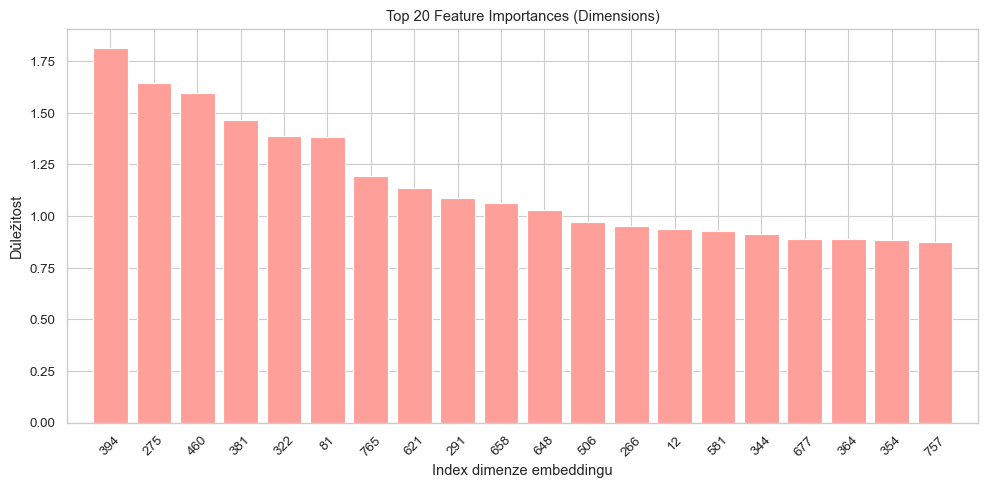

In [25]:
print("\n📊 2. KALIBRACE A DŮLEŽITOST RYSŮ")
viz.plot_model_calibration(y_test, y_probs)

# Feature importance voláme na objektu 'clf' (nebo 'model'), který jste trénovali naposledy
if 'clf' in locals():
    viz.plot_feature_importance(clf)
elif 'model' in locals():
    viz.plot_feature_importance(model)

[autoreload of visualization failed: Traceback (most recent call last):
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\dobes\Documents\Anaconda Python\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x83 in position 6857: character maps to <undefined>
]



📊 3. ANALÝZA CHYB V EMBEDDING PROSTORU
   ✅ Používám již vypočítané projekce.
   🔹 Vykresluji PCA...


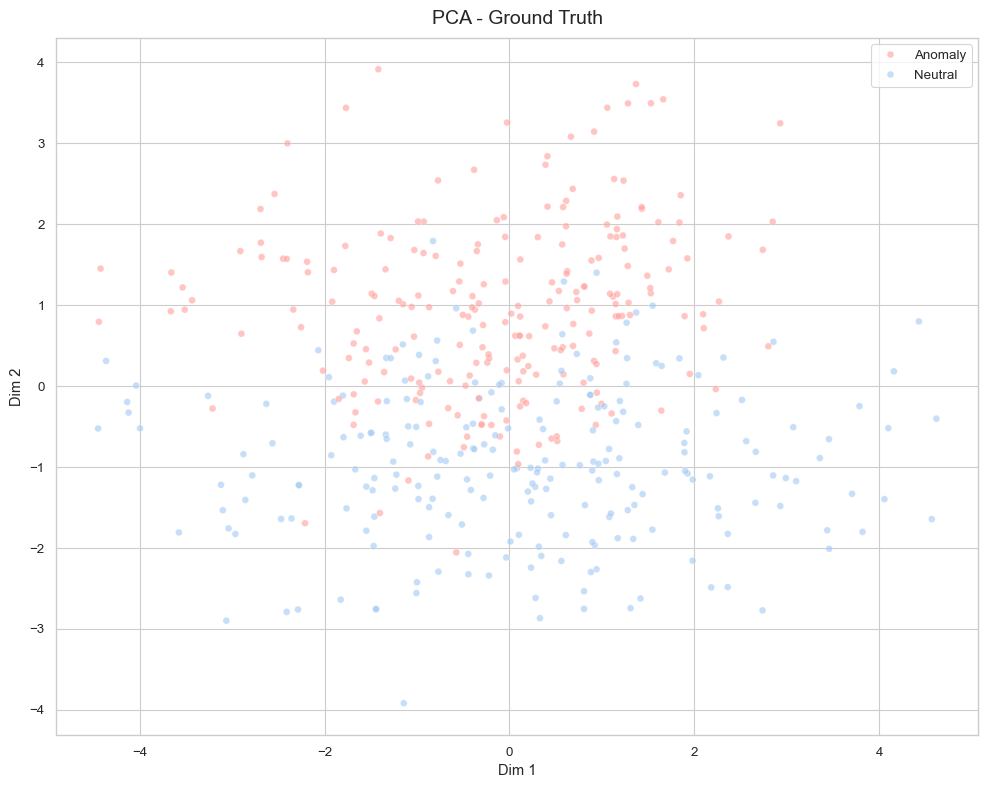

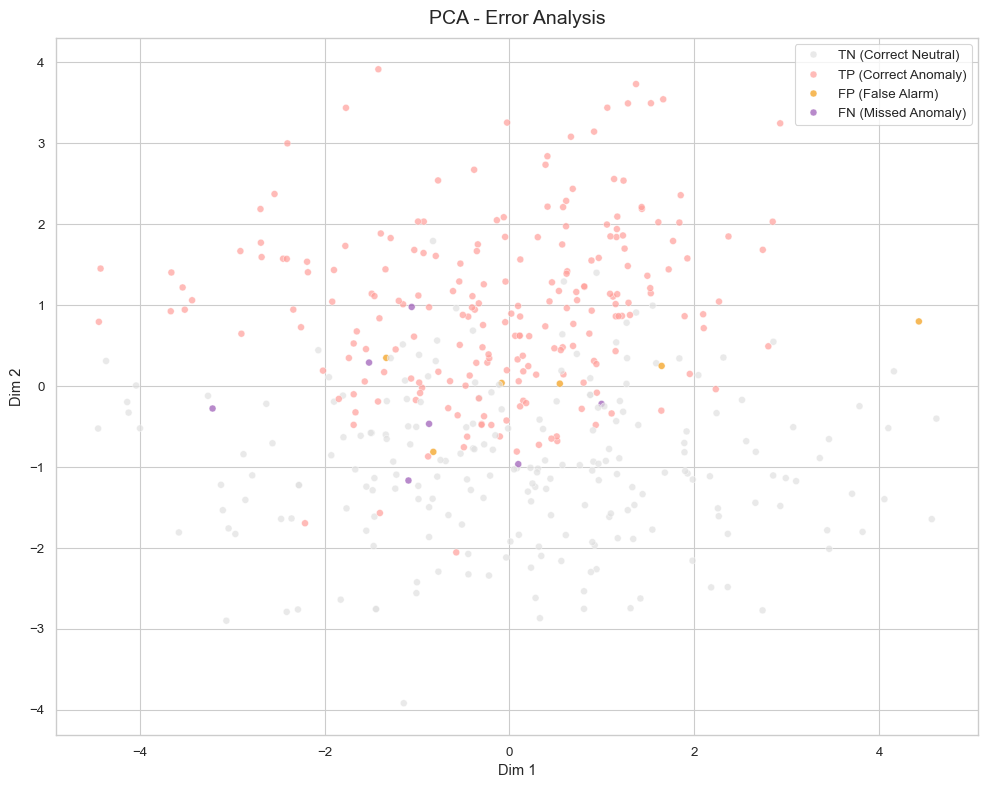

   🔹 Vykresluji UMAP...


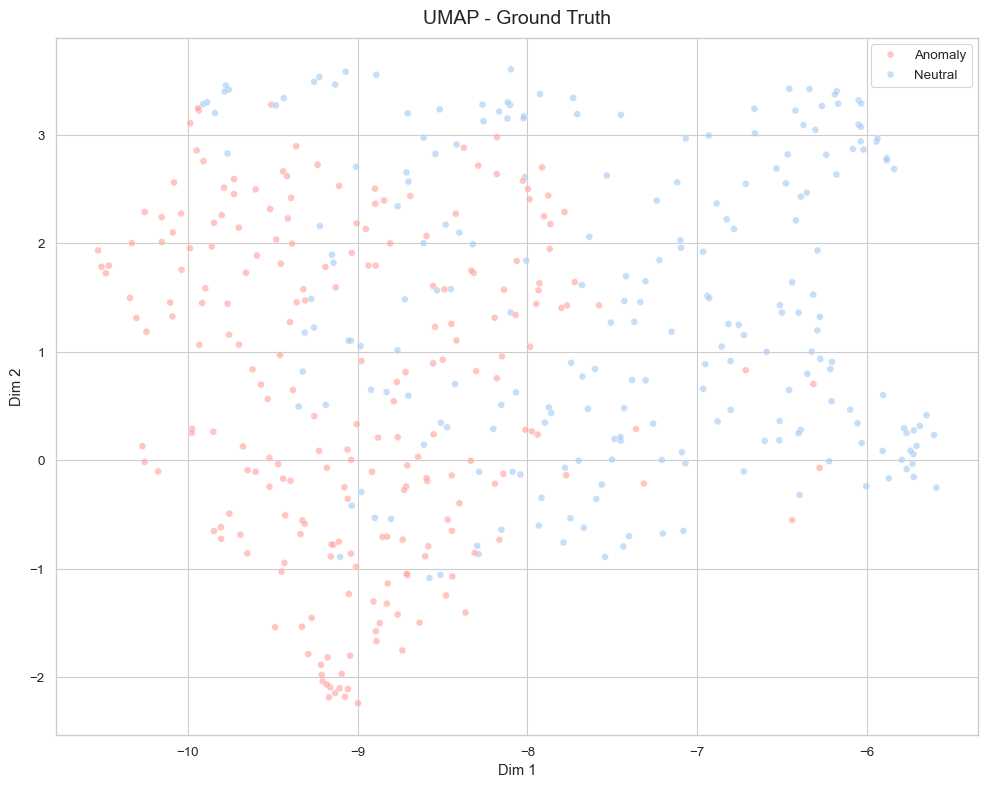

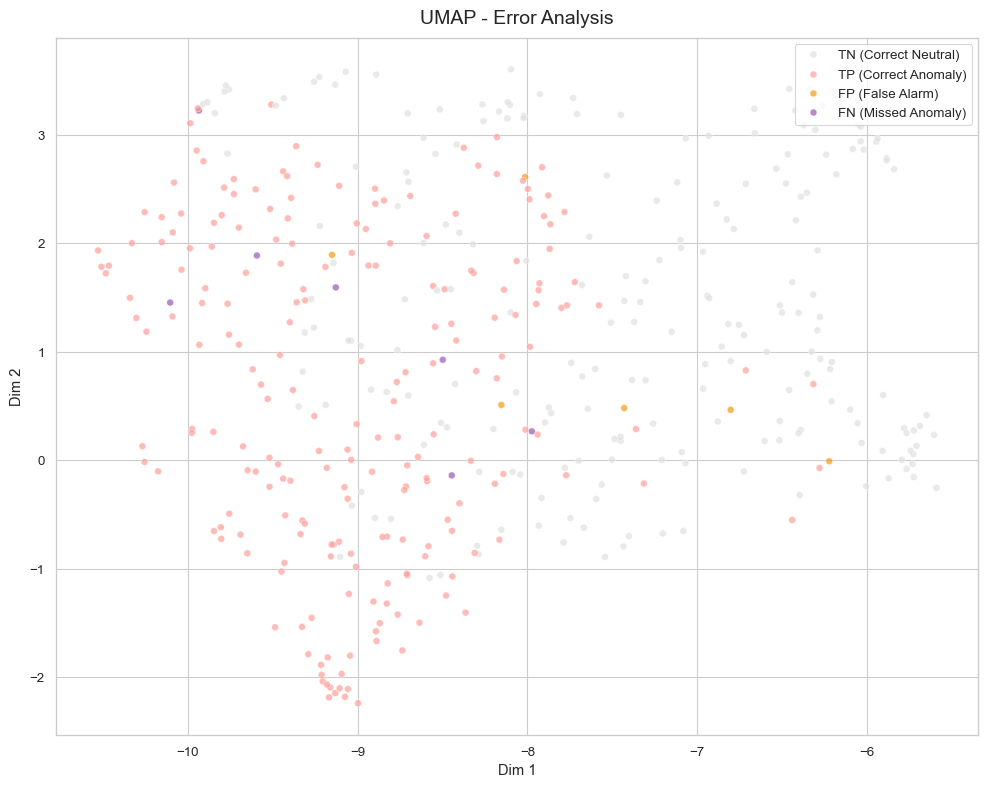

In [27]:
print("\n📊 3. ANALÝZA CHYB V EMBEDDING PROSTORU")
# 3.1 Výpočet projekcí (PCA, UMAP...)
if 'projections' not in locals():
    print("   ⏳ Počítám projekce (může to chvíli trvat)...")
    projections, indices = viz.compute_projections(
        X_test, 
        methods=['PCA', 'UMAP', 't-SNE'],
        max_samples=2000
    )
    # Synchronizace y_test/y_pred s indexy projekce (kvůli subsamplingu)
    y_test_sub = y_test[indices]
    y_pred_sub = y_pred[indices]
else:
    print("   ✅ Používám již vypočítané projekce.")

# 3.2 Vykreslení
for method, coords in projections.items():
    print(f"   🔹 Vykresluji {method}...")
    
    # A) Ground Truth
    labels_gt = ['Anomaly' if y==1 else 'Neutral' for y in y_test_sub]
    viz.plot_embedding_projection(
        coords, 
        labels_gt, 
        palette={'Neutral': config.COLORS['l0'], 'Anomaly': config.COLORS['l1']},
        title=f"{method} - Ground Truth",
        alpha=0.6
    )
    
    # B) Error Analysis (Kde model chybuje)
    viz.plot_error_analysis_projection(
        coords, 
        y_test_sub, 
        y_pred_sub, 
        method_name=method
    )

---
### S1c - bootsraping 

V práci pak vyřešit otázku tohoto: **Oversampling (SMOTE / ADASYN):**


🔄 SPUŠTÍM S1c BOOTSTRAPING
   Modely: ['LogReg', 'SVM (RBF)']
   Iterací: 100
   Filtr: mild


Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Hotovo za 18.4 sekund.


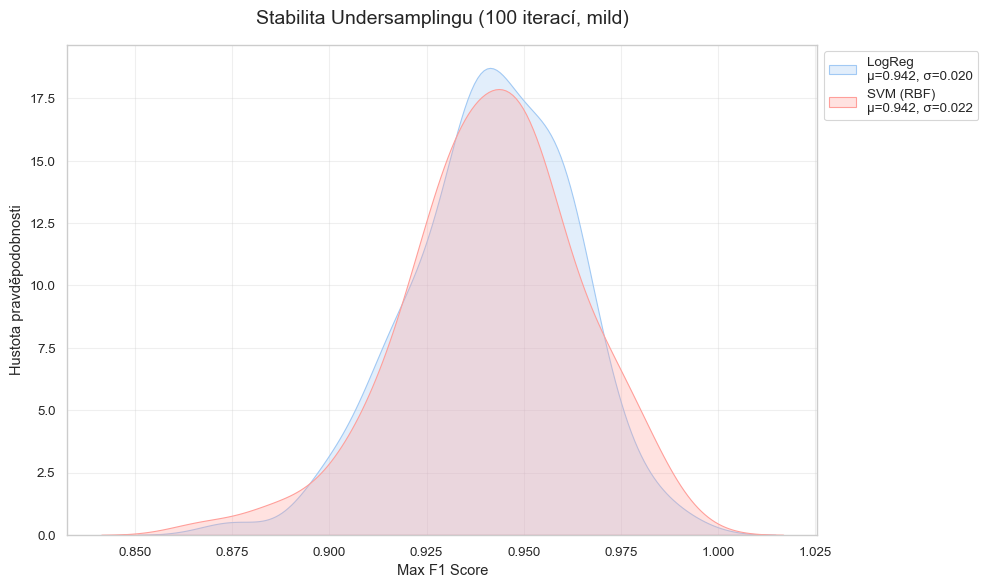


📊 STATISTICKÉ VÝSLEDKY:
🔹 LogReg: Mean=0.9415 | Std=0.0203 | 95% CI: [0.8991, 0.9763]
🔹 SVM (RBF): Mean=0.9415 | Std=0.0222 | 95% CI: [0.8926, 0.9804]


In [29]:
# --- KONFIGURACE S1c ---
SCENARIO_BOOTSTRAP = 'S1b'  # Používáme S1b (Undersampling), protože chceme testovat jeho nestabilitu
FILTER_TYPE = 'mild'        # Zvolený filtr
N_BOOTSTRAPS = 100          # Pro test dejte 10, pro finále 100 nebo 1000
MODELS_TO_TEST = ["LogReg", "SVM (RBF)"] # Vybraní kandidáti

print(f"🔄 SPUŠTÍM S1c BOOTSTRAPING")
print(f"   Modely: {MODELS_TO_TEST}")
print(f"   Iterací: {N_BOOTSTRAPS}")
print(f"   Filtr: {FILTER_TYPE}")

# Ukládání výsledků
bootstrap_scores = defaultdict(list)

# Hlavní smyčka
start_global = time.time()

for i in tqdm(range(N_BOOTSTRAPS), desc="Bootstrapping"):
    # 1. Přenačtení dat s novým seedem (to zajistí jiné namíchání undersamplingu)
    # Pozor: load_data_for_scenario pro S1b používá RandomUnderSampler, který bere seed
    X_train, X_test, y_train, y_test = load_data_for_scenario(
        SCENARIO_BOOTSTRAP, 
        filter_type=FILTER_TYPE, 
        random_state=i # Měníme seed v každé iteraci!
    )
    
    for model_name in MODELS_TO_TEST:
        try:
            # 2. Inicializace a trénink
            # random_state fixujeme u modelu, abychom měřili vliv dat, ne vnitřní náhody modelu
            clf = models.get_supervised_model(model_name, random_state=42) 
            clf.fit(X_train, y_train)
            
            # 3. Predikce
            if hasattr(clf, "predict_proba"):
                y_probs = clf.predict_proba(X_test)[:, 1]
            else:
                y_probs = clf.decision_function(X_test)
                
            # 4. Výpočet Max F1 (stejná metrika jako jinde)
            _, _, max_f1, _, _ = calculate_metrics_at_max_f1(y_test, y_probs)
            
            bootstrap_scores[model_name].append(max_f1)
            
        except Exception as e:
            print(f"Chyba u {model_name} v iteraci {i}: {e}")

print(f"✅ Hotovo za {time.time() - start_global:.1f} sekund.")

viz.plot_bootstrap_results(
    bootstrap_scores, 
    metric_name="Max F1 Score", 
    title=f"Stabilita Undersamplingu ({N_BOOTSTRAPS} iterací, {FILTER_TYPE})"
)